# Object Detection

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from helpers import ImageManager
np.random.seed(0)

# Training

In [39]:
def plot(dim, figsize, imgs, titles=None, gray=False, group_images=False):
    fig, ax = plt.subplots(dim[0], dim[1], figsize=figsize)
    ax = ax.flatten()
    for i in range(len(imgs)):
        if gray:
            ax[i].imshow(imgs[i], cmap='gray'), ax[i].set_xticks([]), ax[i].set_yticks([])
        else:
            ax[i].imshow(imgs[i]), ax[i].set_xticks([]), ax[i].set_yticks([])
        if titles:
            ax[i].set_title(titles[i])
            if group_images and i % 5 == 0:
                ax[i].set_ylabel('group image {}'.format(i // 5), size='large')
    
    if len(ax) > len(imgs):
        fig.delaxes(ax[len(ax)-1])

In [40]:
# Get Data using the Helper Class
mng = ImageManager()
training = dict()
testing = dict()
testing["images"] = mng.get_testing_images(color=cv2.COLOR_BGR2GRAY)
training["images"] = mng.get_training_images(color=cv2.COLOR_BGR2GRAY)
_, testing["bounds"] = mng.update_testing_bounds()
_, training["bounds"] = mng.update_training_bounds()
images_train = mng.training_faces

### 2. HoG Feautres

In [41]:
def find_hog_features(images, cell_size=4, block_size=2, nbins=9):
    features = []
    
    for img in images:
        w = img.shape[0]
        h = img.shape[1]
        h_cells = h // cell_size
        w_cells = w // cell_size
        n_cells = (w_cells, h_cells)
        
        # create HoG Object
        hog = cv2.HOGDescriptor(_winSize=(h_cells * cell_size, w_cells * cell_size),
                                _blockSize=(block_size * cell_size, block_size * cell_size),
                                _blockStride=(cell_size, cell_size),
                                _cellSize=(cell_size, cell_size),
                                _nbins=nbins)

        # Compute HoG features
        hog_feats = hog.compute(img).reshape(h_cells - block_size + 1,
                                             w_cells - block_size + 1,
                                             block_size, block_size,
                                             nbins).transpose((1, 0, 3, 2, 4))
        features.append(hog_feats)
        
    return features

### 3. Mean Feature Map

In [42]:
feats = find_hog_features(images_train)
feat_sum = 0

for feat in feats:
    feat_sum += feat
    
mean_map = feat_sum / len(feats)

### 5. Orientation Channels

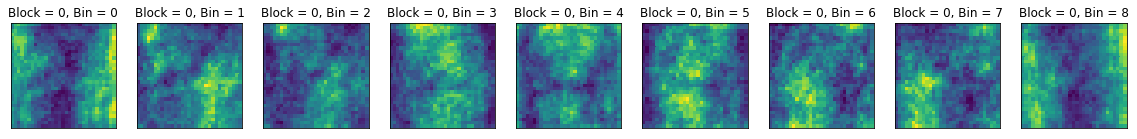

In [43]:
plt.figure(figsize = (20,100))

for i in range(9):
    plt.subplot(1,9,i+1)
    plt.pcolor(mean_map[:, :, 0,0,i])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Block = 0, Bin = {}".format(i)), plt.xticks([]), plt.yticks([])

# Testing

In [44]:
group_images_gray = mng.get_group_images(color=cv2.COLOR_BGR2GRAY)

In [45]:
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [46]:
faces = []
for i, img_gray in enumerate(group_images_gray):
    faces.append(
        faceCascade.detectMultiScale(img_gray, scaleFactor=1.2, minNeighbors=6, 
                                     minSize=(100, 100), flags = cv2.CASCADE_SCALE_IMAGE)
    )
    print("Found {} faces! for image_gray[{}]".format(len(faces[-1]), i))

Found 5 faces! for image_gray[0]
Found 5 faces! for image_gray[1]
Found 5 faces! for image_gray[2]
Found 5 faces! for image_gray[3]
Found 5 faces! for image_gray[4]


In [47]:
extracted_faces_labels = [['anees', 'adham', 'abdullah', 'saleh', 'mustafa'], 
                          ['adham', 'abdullah', 'mustafa', 'saleh', 'anees'], 
                          ['abdullah', 'mustafa', 'anees', 'saleh', 'adham'], 
                          ['adham', 'abdullah', 'mustafa', 'anees', 'saleh'], 
                          ['abdullah', 'saleh', 'anees', 'adham', 'mustafa']]
Y_test_faces = [face for faces in extracted_faces_labels for face in faces]

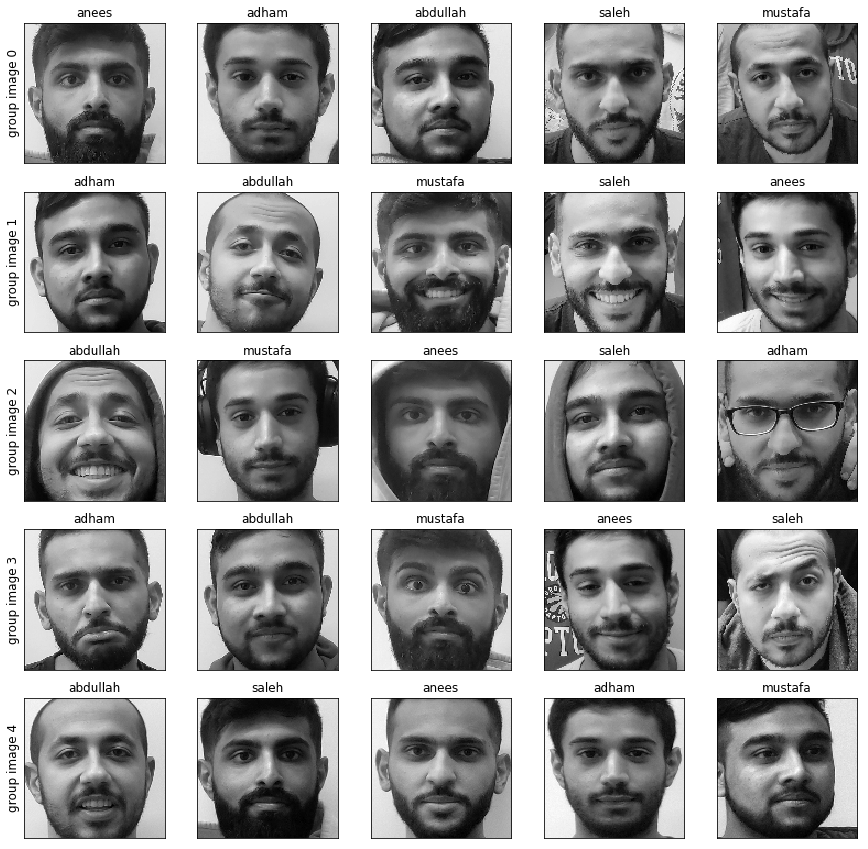

In [56]:
extracted_faces = [mng.extract_faces(group_images_gray[i], faces[i]) for i, _ in enumerate(faces)]
extracted_faces = [face for faces in extracted_faces for face in faces]
# extracted_faces = [sorted(j, key=np.mean) for j in extracted_faces]
# extracted_faces = [face for faces in extracted_faces for face in faces]
plot((5, 5), (15, 15), extracted_faces, Y_test_faces, gray=True, group_images=True)

### 1. Extract Overlapping Windows

In [200]:
windows = extract_windows(test_image, 30, [200, 150])
len(windows)

63

### 2. Resize to 128x128

In [201]:
for i, w in enumerate(windows):
    windows[i] = cv2.resize(w, (128, 128))

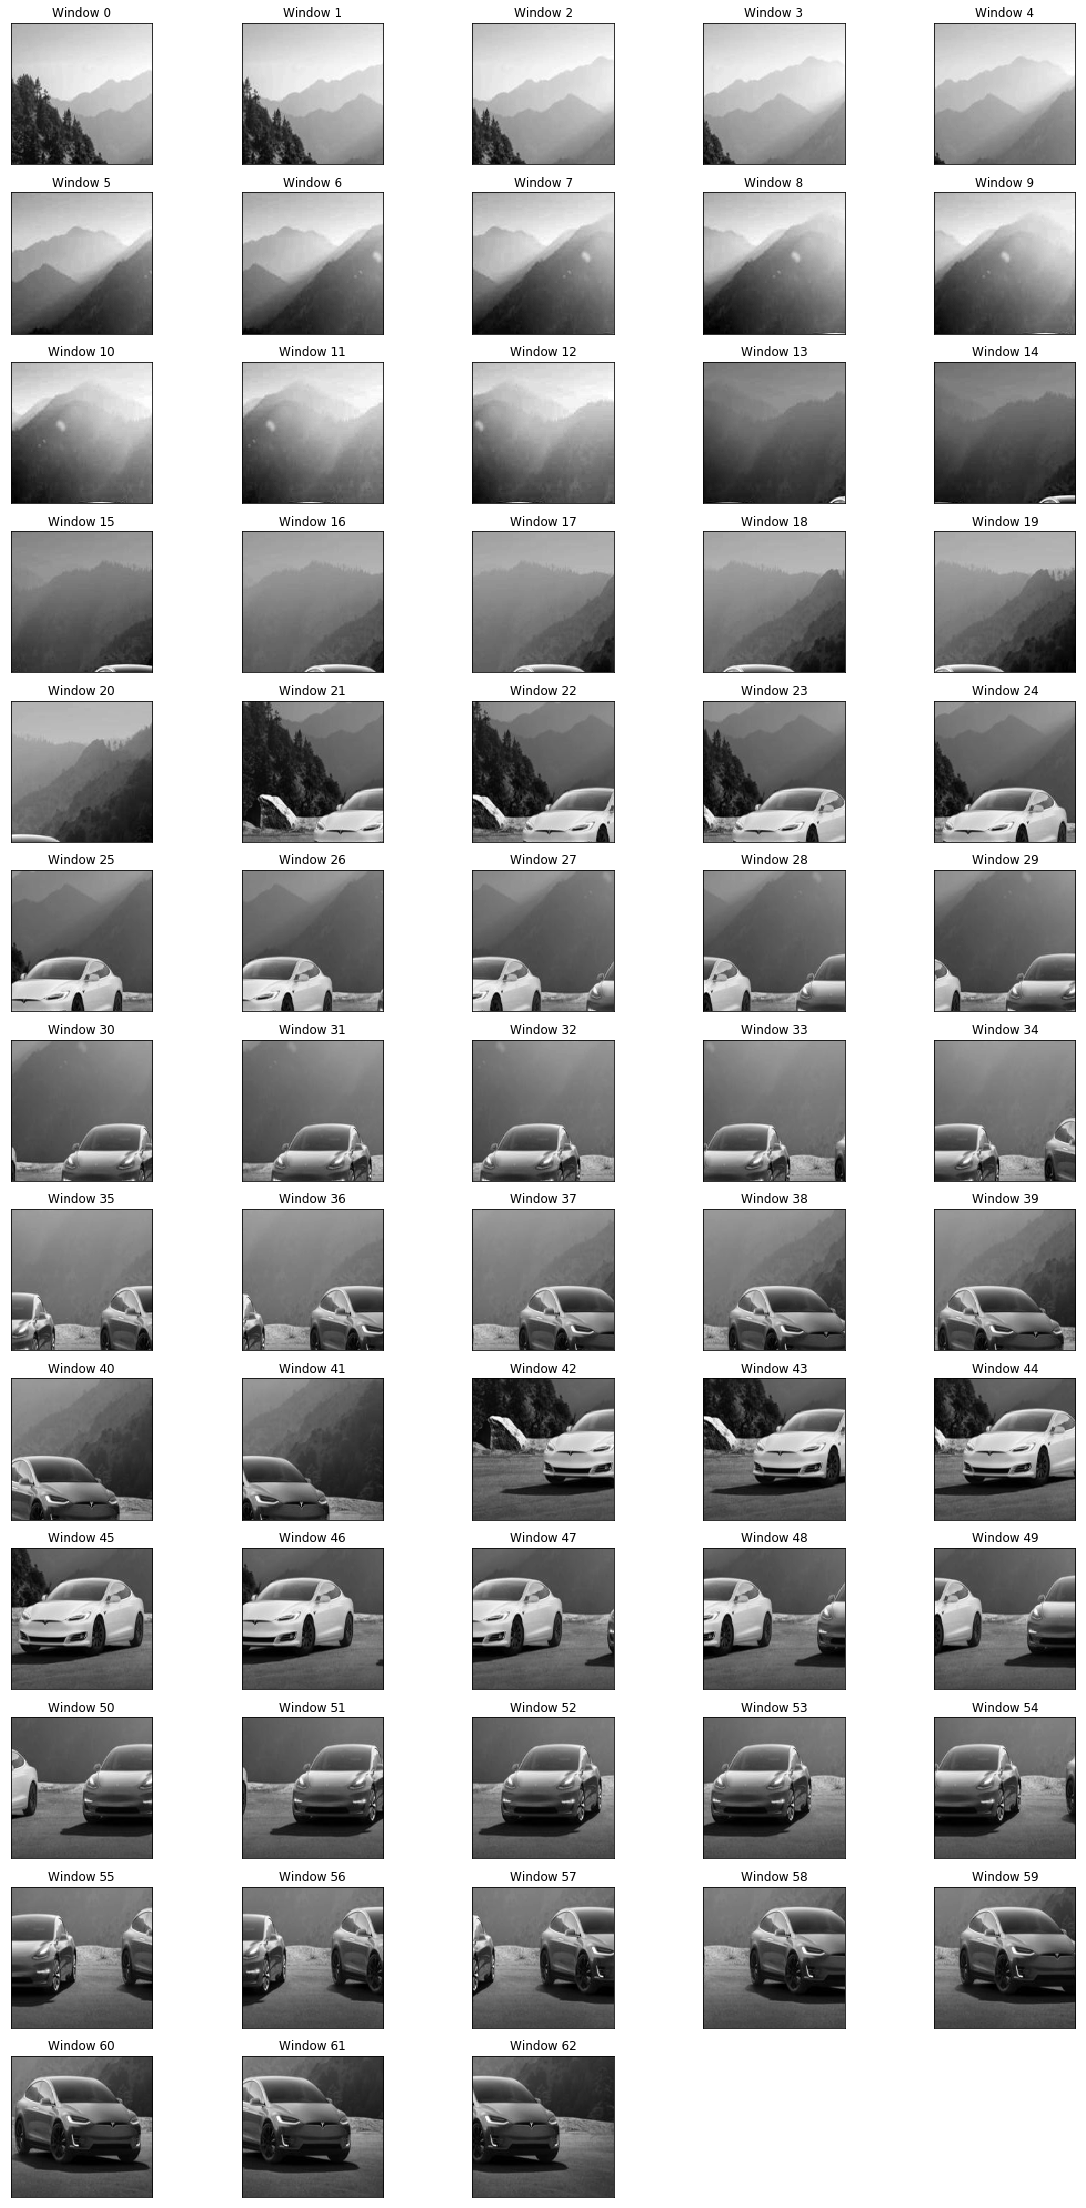

In [202]:
plt.figure(figsize = (20,40))
for i in range(len(windows)):
    plt.subplot(13,5,i+1)
    plt.imshow(windows[i], cmap='gray')
    plt.title("Window {}".format(i)), plt.xticks([]), plt.yticks([])

### 3. Euclidean Distance

In [203]:
windows_feats = []
dists = []
for w in windows:
    w_feat = find_hog_features([w])[0]
    windows_feats.append(w_feat)
    dists.append(np.linalg.norm(w_feat-mean_map))
# ['{}: {}'.format(i,x) for i, x in enumerate(dists)]

In [204]:
dists_flipped = []
for w_feat in windows_feats:
    dists_flipped.append(np.linalg.norm(mean_map_flipped - w_feat))

# ['{}: {}'.format(i,x) for i, x in enumerate(dists_flipped)]

### 4. Threshold Two Distances - Display Detected Window

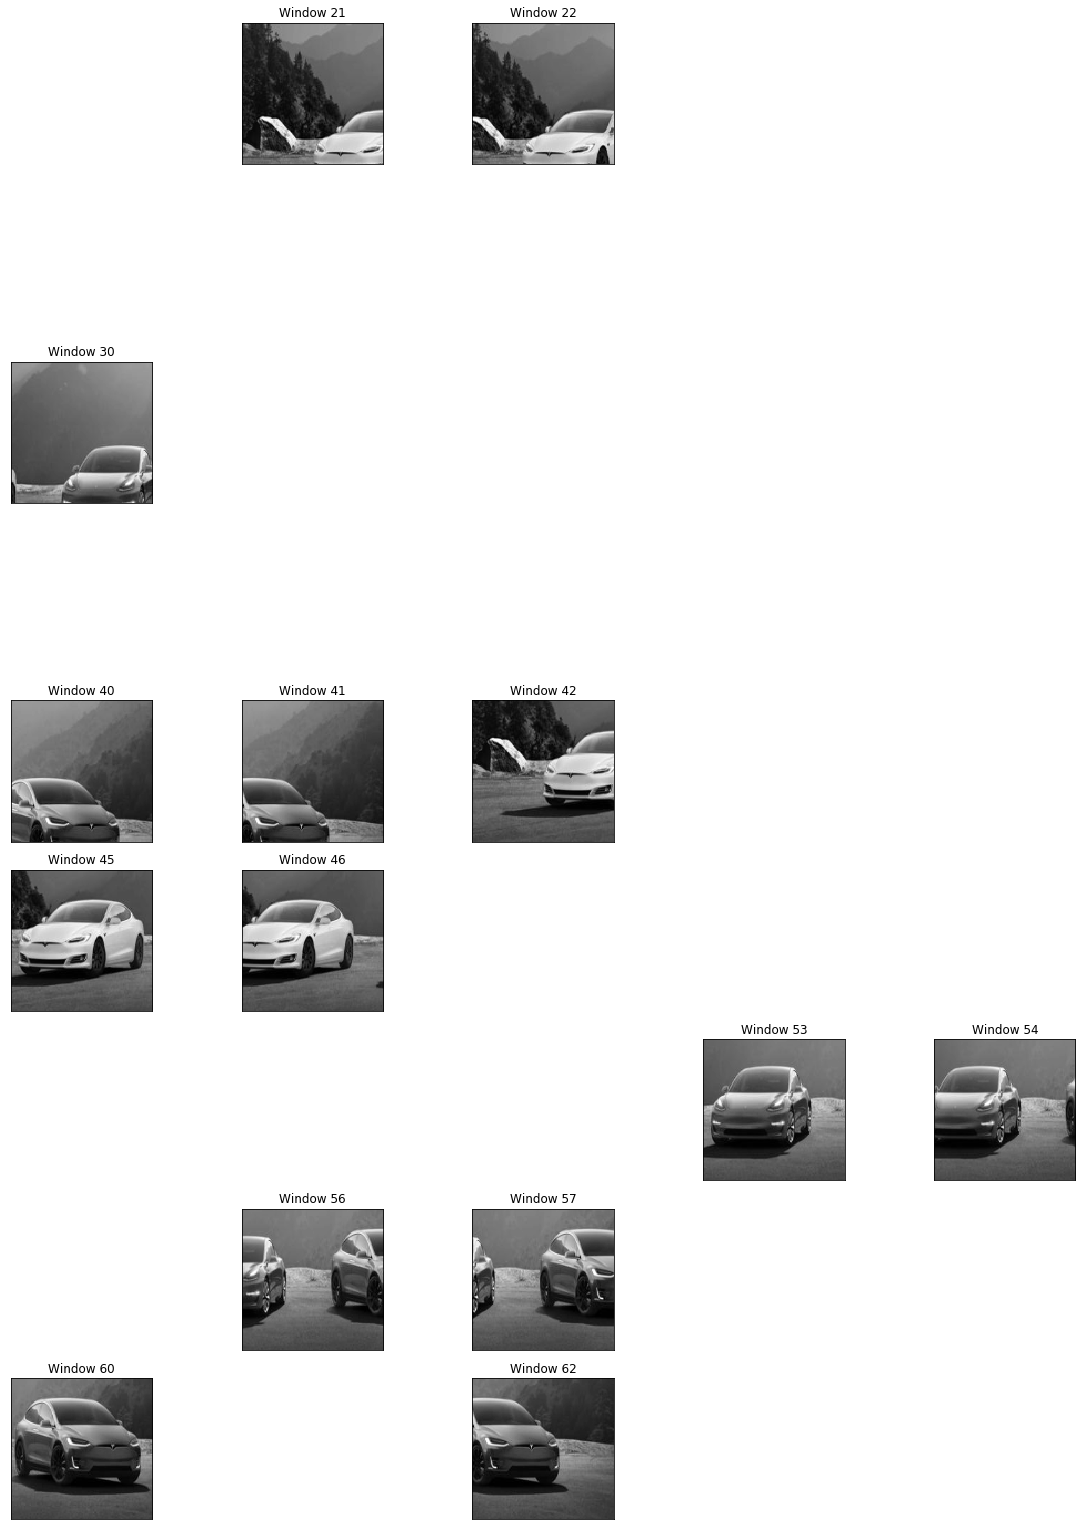

In [205]:
plt.figure(figsize = (20,40))
T = 22
for i in range(len(windows)):
    if dists[i] < T or dists_flipped[i] < T:
        plt.subplot(13,5,i+1)
        plt.imshow(windows[i], cmap='gray')
        plt.title("Window {}".format(i)), plt.xticks([]), plt.yticks([])

### 5. Optimization

**The results were optimized with the following parameters after about 50 trial and error runs:**

1. stride = 50
2. window size = 150 x 200
3. number of windows = 63
4. Thresholds, T = 22
5. number of detected windows = 14

**NOTE 1: Images 45, 53 and 60 show perfect car windows that are passing**

**NOTE 2: No scenary windows are detected as cars**